<a href="https://colab.research.google.com/github/pyohamen/data-science/blob/master/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%82%AC%EC%9D%B4%EC%96%B8%EC%8A%A4%EC%9D%91%EC%9A%A9%EA%B3%BC%EC%A0%95/4-1_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8/Code/Code10_airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb 데이터를 이용한 회귀분석
#### (https://www.kaggle.com/stevezhenghp/airbnb-price-prediction)

# 1. 데이터 불러오기 및 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving airbnb.xlsx to airbnb.xlsx


In [ ]:
data = pd.read_excel('airbnb.xlsx')
data

In [ ]:
import io
data = pd.read_excel(io.BytesIO(uploaded['airbnb.xlsx']))

### 1.1 “number_of_reviews”가 11개 이상인 데이터만 추출

In [ ]:
data2 = data.copy()

In [ ]:
data2 = data2[data2['number_of_reviews']>=11].reset_index(drop=True)
data2.shape

(29016, 29)

### 1.2 “property_type”은 ‘House’, ‘Aprtment’, ’Other’ 등의 3범주로 변환 /   I_house, I_apartment 등의 2개 더미변수를 생성하고, “property_type”은 삭제

In [ ]:
data2['I_house']=np.where(data2['property_type'] == 'House', 1, 0)
data2['I_apt']=np.where(data2['property_type'] == 'Apartment', 1, 0)

In [ ]:
print(data2['I_house'].value_counts())
print(data2['I_apt'].value_counts())
data2.drop(['property_type'], axis=1, inplace=True)

0    21703
1     7313
Name: I_house, dtype: int64
1    18256
0    10760
Name: I_apt, dtype: int64


### 1.3	“room_type”은 ‘share room’=1, ‘private room’=2, ‘entire home/apt’=3 으로 정수형으로 변환

In [ ]:
data2['room_type']=data2['room_type'].replace({'Shared room':1, 'Private room':2, 'Entire home/apt':3})
print(data2['room_type'].value_counts())

3    17206
2    11178
1      632
Name: room_type, dtype: int64


### 1.4	“amenities”는 amenities에 포함된 편의시설의 갯수로 정의함

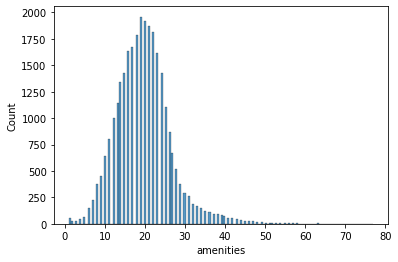

In [ ]:
data2['amenities'] = data2['amenities'].str.count(',')+1
sns.histplot(data=data2, x='amenities')
plt.show()

### 1.5	“bed_type”은 ‘Real Bed’인 경우는 1, 그 외의 경우는 0으로 더미변수화 함

In [ ]:
data2['bed_type']=np.where(data2['bed_type'] == 'Real Bed', 1, 0)
data2['bed_type'].value_counts()

1    28167
0      849
Name: bed_type, dtype: int64

### 1.6 	“cancellation_policy”는 5개의 순서가 존재하는 범주형이므로, 이를 1,2,3,4,5의 정수형으로 변환함 
* (flexible=1, moderate=2, strict=3, super_strict_30=4, super_strict60=5)

In [ ]:
data2['cancellation_policy']=data2['cancellation_policy'].replace(
    {'flexible':1,'moderate':2,'strict':3,'super_strict_30':4,'super_strict_60':5})
print(data2['cancellation_policy'].value_counts())

3    16015
2     9071
1     3899
4       29
5        2
Name: cancellation_policy, dtype: int64


### 1.7 	“cleaning fee” 는 더미변수화

In [ ]:
data2['cleaning_fee']=np.where(data2['cleaning_fee'] == True, 1, 0)
data2['cleaning_fee'].value_counts()

1    24389
0     4627
Name: cleaning_fee, dtype: int64

### 1.8 	“description” 변수는 문자열의 길이로 정의 (더 긴 소개문을 제공한 곳은 더 비싼지 여부 확인해보기 위해)

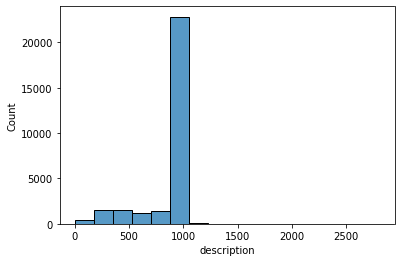

In [ ]:
data2['description'] = data2['description'].str.len()
sns.histplot(data=data2, x='description')
plt.show()

### 1.9 “host_identity_verified” 변수는 더미변수화

In [ ]:
data2['host_identity_verified']=np.where(data2['host_identity_verified'] == 't', 1, 0)
data2['host_identity_verified'].value_counts()

1    22783
0     6233
Name: host_identity_verified, dtype: int64

### 1.10	“instant_bookable” 변수는 더미변수화

In [ ]:
data2['instant_bookable']=np.where(data2['instant_bookable'] == 't', 1, 0)
data2['instant_bookable'].value_counts()

0    20370
1     8646
Name: instant_bookable, dtype: int64

### 1.11	“latitude”와 “longitude”를 이용하여 “도심의 중심위치로부터의 거리” 라는 변수를 추가

|CITY|LAT|LONG|
|:-:|:-:|:-:|
|NYC|40.664167|-73.938611|
|SF|37.7793|-122.4192|
|DC|38.895|-77.036667|
|LA|34.05|-118.25|
|Chicago|41.881944|-87.627778|
|Boston|42.357778|-71.061667|
|||출처: GeoHack|

In [ ]:
city_center = pd.DataFrame([['NYC', 40.664167, -73.938611], ['SF', 37.7793, -122.4192], ['DC', 38.895, -77.036667],
             ['LA', 34.05, -118.25], ['Chicago', 41.881944, -87.627778], ['Boston', 42.357778, -71.061667]],
            columns=['city', 'city_lat', 'city_long'])

In [ ]:
data2 = pd.merge(data2, city_center, how='left', on='city')

In [ ]:
data2['distance_from_city_center'] = np.sqrt((data2['latitude']-data2['city_lat'])**2
                                             +(data2['longitude']-data2['city_long'])**2)
data2

,id,log_price,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,I_house,I_apt,city_lat,city_long,distance_from_city_center
0,11825529,4.418841,3,21,3,1.0,1,2,1,LA,1000,2010-03-17,t,0,1.00,2003-03-17,1,2021-04-17,33.980454,-118.462821,Beach Town Studio and Parking!!!11h,NaN,15,97.0,https://a0.muscache.com/im/pictures/4c920c60-4...,90292,1.0,1.0,0,1,34.050000,-118.250000,0.223896
1,180792,4.787492,2,21,2,1.0,1,2,1,SF,1000,2013-02-16,t,0,1.00,2004-06-15,0,2024-09-17,37.781128,-122.501095,Cozy Garden Studio - Private Entry,Richmond District,159,99.0,https://a0.muscache.com/im/pictures/0ed6c128-7...,94121,1.0,1.0,1,0,37.779300,-122.419200,0.081916
2,5578513,4.605170,2,15,2,1.0,1,3,1,NYC,1000,2028-04-13,t,1,1.00,2027-03-13,0,2015-11-16,40.723883,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009,1.0,1.0,0,1,40.664167,-73.938611,0.074936
3,17423675,5.010635,3,22,4,1.5,1,3,1,LA,1000,2002-07-15,t,1,1.00,2011-06-15,0,2018-11-16,33.875862,-118.403293,Sand Section Beach Bungalow,Hermosa Beach,29,97.0,NaN,90254,2.0,2.0,1,0,34.050000,-118.250000,0.231997
4,2658946,5.298317,3,25,6,1.5,1,3,1,DC,1000,2018-02-17,t,1,1.00,2012-10-12,1,1930-04-17,38.919630,-77.031189,Charming 2 bdrm in trendy U/14th streets w/par...,U Street Corridor,13,89.0,NaN,20009,2.0,3.0,0,1,38.895000,-77.036667,0.025232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29011,11829011,5.135798,3,24,2,1.0,1,2,1,SF,1002,2010-12-11,t,0,1.00,2026-09-11,0,2013-11-15,37.789989,-122.407384,WorldMark W'ndm Union Square Studio,Union Square,24,98.0,https://a0.muscache.com/im/pictures/9a99e2de-c...,94108,1.0,1.0,0,1,37.779300,-122.419200,0.015933
29012,808802,4.248495,2,13,2,1.0,1,2,1,LA,1000,2025-03-16,t,1,0.75,2018-03-15,0,2019-02-17,34.092639,-118.343921,Private Bed/Bathroom in Cute House!,NaN,36,91.0,https://a0.muscache.com/im/pictures/ae2e48de-6...,90038,1.0,1.0,1,0,34.050000,-118.250000,0.103147
29013,13281809,5.043425,3,16,4,2.0,1,2,1,LA,302,2015-08-16,t,0,1.00,2003-05-16,0,2015-04-17,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0,0,1,34.050000,-118.250000,0.230600
29014,18688039,5.220356,3,31,5,1.0,1,2,1,NYC,1000,2003-01-15,t,1,1.00,2005-01-12,1,2010-09-17,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206,2.0,2.0,0,1,40.664167,-73.938611,0.042748


### 1.12	로그가격비(log_price_ratio)’ 변수를 생성하시오. 여기서, 가격비는 아래와 같다.
* $\text{로그가격비}=log(\frac{\text{원가격}}{\text{도시별 평균가격}})$
* 여기서 '원가격'$=e^{\text{log_price}}$, '도시별 평균가격'은 같은 도시내의 '원가격'의 평균값을 의미한다.

In [ ]:
data2['price'] = np.exp(data2['log_price'])

In [ ]:
avg_price_by_city = data2.groupby('city', as_index=False).mean()[['city', 'price']]
avg_price_by_city.rename(columns={'price':'avg_price_by_city'},inplace=True)
avg_price_by_city

,city,avg_price_by_city
0,Boston,152.486037
1,Chicago,116.881828
2,DC,137.181602
3,LA,140.122352
4,NYC,142.604285
5,SF,189.819051


In [ ]:
data2 = pd.merge(data2, avg_price_by_city, how='left', on='city')

In [ ]:
data2['log_price_ratio'] = np.log(data2['price']/data2['avg_price_by_city'])
data2

,id,log_price,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,I_house,I_apt,city_lat,city_long,distance_from_city_center,price,avg_price_by_city,log_price_ratio
0,11825529,4.418841,3,21,3,1.0,1,2,1,LA,1000,2010-03-17,t,0,1.00,2003-03-17,1,2021-04-17,33.980454,-118.462821,Beach Town Studio and Parking!!!11h,NaN,15,97.0,https://a0.muscache.com/im/pictures/4c920c60-4...,90292,1.0,1.0,0,1,34.050000,-118.250000,0.223896,83.0,140.122352,-0.523675
1,180792,4.787492,2,21,2,1.0,1,2,1,SF,1000,2013-02-16,t,0,1.00,2004-06-15,0,2024-09-17,37.781128,-122.501095,Cozy Garden Studio - Private Entry,Richmond District,159,99.0,https://a0.muscache.com/im/pictures/0ed6c128-7...,94121,1.0,1.0,1,0,37.779300,-122.419200,0.081916,120.0,189.819051,-0.458580
2,5578513,4.605170,2,15,2,1.0,1,3,1,NYC,1000,2028-04-13,t,1,1.00,2027-03-13,0,2015-11-16,40.723883,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009,1.0,1.0,0,1,40.664167,-73.938611,0.074936,100.0,142.604285,-0.354903
3,17423675,5.010635,3,22,4,1.5,1,3,1,LA,1000,2002-07-15,t,1,1.00,2011-06-15,0,2018-11-16,33.875862,-118.403293,Sand Section Beach Bungalow,Hermosa Beach,29,97.0,NaN,90254,2.0,2.0,1,0,34.050000,-118.250000,0.231997,150.0,140.122352,0.068119
4,2658946,5.298317,3,25,6,1.5,1,3,1,DC,1000,2018-02-17,t,1,1.00,2012-10-12,1,1930-04-17,38.919630,-77.031189,Charming 2 bdrm in trendy U/14th streets w/par...,U Street Corridor,13,89.0,NaN,20009,2.0,3.0,0,1,38.895000,-77.036667,0.025232,200.0,137.181602,0.377012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29011,11829011,5.135798,3,24,2,1.0,1,2,1,SF,1002,2010-12-11,t,0,1.00,2026-09-11,0,2013-11-15,37.789989,-122.407384,WorldMark W'ndm Union Square Studio,Union Square,24,98.0,https://a0.muscache.com/im/pictures/9a99e2de-c...,94108,1.0,1.0,0,1,37.779300,-122.419200,0.015933,170.0,189.819051,-0.110273
29012,808802,4.248495,2,13,2,1.0,1,2,1,LA,1000,2025-03-16,t,1,0.75,2018-03-15,0,2019-02-17,34.092639,-118.343921,Private Bed/Bathroom in Cute House!,NaN,36,91.0,https://a0.muscache.com/im/pictures/ae2e48de-6...,90038,1.0,1.0,1,0,34.050000,-118.250000,0.103147,70.0,140.122352,-0.694021
29013,13281809,5.043425,3,16,4,2.0,1,2,1,LA,302,2015-08-16,t,0,1.00,2003-05-16,0,2015-04-17,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0,0,1,34.050000,-118.250000,0.230600,155.0,140.122352,0.100909
29014,18688039,5.220356,3,31,5,1.0,1,2,1,NYC,1000,2003-01-15,t,1,1.00,2005-01-12,1,2010-09-17,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206,2.0,2.0,0,1,40.664167,-73.938611,0.042748,185.0,142.604285,0.260282


### 1.13	'id', 'first_review', 'host_has_profile_pic', 'host_since','last_review',             'latitude', 'longitude', 'city_lat', 'city_long', 'price', 'avg_price_by_city', 'name', 'neighbourhood', 'thumbnail_url', 'zipcode', 'city', 'log_price' 변수를 삭제

In [ ]:
delete_var= ['id','first_review','host_has_profile_pic','host_since','last_review',
             'latitude','longitude','city_lat','city_long','price','avg_price_by_city',
             'name','neighbourhood','thumbnail_url','zipcode','city','log_price']
data2.drop(delete_var, axis=1, inplace=True)

### 1.14	결측치가 있는 데이터는 삭제

In [ ]:
data2.isnull().sum()

room_type                       0
amenities                       0
accommodates                    0
bathrooms                     101
bed_type                        0
cancellation_policy             0
cleaning_fee                    0
description                     0
host_identity_verified          0
host_response_rate           1597
instant_bookable                0
number_of_reviews               0
review_scores_rating           22
bedrooms                       42
beds                           18
I_house                         0
I_apt                           0
distance_from_city_center       0
log_price_ratio                 0
dtype: int64

In [ ]:
data2 = data2.dropna().reset_index(drop=True)

In [ ]:
data2.dtypes

room_type                      int64
amenities                      int64
accommodates                   int64
bathrooms                    float64
bed_type                       int64
cancellation_policy            int64
cleaning_fee                   int64
description                    int64
host_identity_verified         int64
host_response_rate           float64
instant_bookable               int64
number_of_reviews              int64
review_scores_rating         float64
bedrooms                     float64
beds                         float64
I_house                        int64
I_apt                          int64
distance_from_city_center    float64
log_price_ratio              float64
dtype: object

In [ ]:
data2.head()

,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,description,host_identity_verified,host_response_rate,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,I_house,I_apt,distance_from_city_center,log_price_ratio
0,3,21,3,1.0,1,2,1,1000,0,1.0,1,15,97.0,1.0,1.0,0,1,0.223896,-0.523675
1,2,21,2,1.0,1,2,1,1000,0,1.0,0,159,99.0,1.0,1.0,1,0,0.081916,-0.458580
2,2,15,2,1.0,1,3,1,1000,1,1.0,0,82,93.0,1.0,1.0,0,1,0.074936,-0.354903
3,3,22,4,1.5,1,3,1,1000,1,1.0,0,29,97.0,2.0,2.0,1,0,0.231997,0.068119
4,3,25,6,1.5,1,3,1,1000,1,1.0,1,13,89.0,2.0,3.0,0,1,0.025232,0.377012


In [ ]:
data2.shape

(27268, 19)

# 2. 변수선택 및 데이터 분할
### 로그가격비를 종속변수로 하여 회귀분석을 수행

In [ ]:
X = data2.drop('log_price_ratio', axis=1)
y = data2['log_price_ratio']

### 2.1 Variable selection을 수행하는데, 변수선택은 랜덤포레스트의 변수중요도를 이용! 변수중요도가 거의 없는 변수들을 제거하고 나서 진행하기로

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

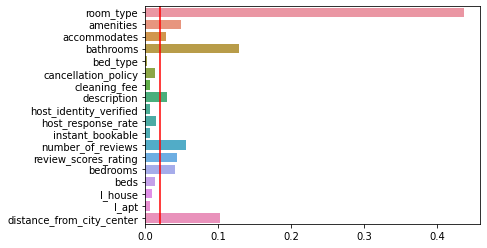

In [ ]:
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.axvline(0.02, color='red')
plt.show()

In [ ]:
xname = ['room_type', 'amenities', 'accommodates', 'bathrooms', 'description', 'number_of_reviews',
       'review_scores_rating', 'bedrooms', 'distance_from_city_center']
X=X[xname].copy()

### 2.2 데이터를 train:test = 5:5의 비율로 분할. 층화추출 사용

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# 3. 회귀분석 9개 모형 수행

### 3.1	선형회귀분석 (statsmodels OLS) 

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
linear = sm.OLS(y_train, sm.add_constant(X_train))
model1 = linear.fit()
y_pred1 = model1.predict(sm.add_constant(X_test))
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_price_ratio   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     2309.
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        07:23:58   Log-Likelihood:                -6623.9
No. Observations:               13634   AIC:                         1.327e+04
Df Residuals:                   13624   BIC:                         1.334e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -3.6382      0.071    -51.244      0.000      -3.777      -3.499
room_type                     0.6106      0.007     83.640      0.000       0.596       0.625
amenities                     0.0031      0.001      5.878      0.000       0.002       0.004
accommodates                  0.0424      0.003     16.773      0.000       0.037       0.047
bathrooms                     0.1054      0.007     14.442      0.000       0.091       0.120
description                1.319e-05   1.52e-05      0.865      0.387   -1.67e-05    4.31e-05
number_of_reviews            -0.0001   7.09e-05     -1.617      0.106      -0.000    2.43e-05
review_scores_rating          0.0139      0.001     18.400      0.000       0.012       0.015
bedrooms                      0.1708      0.006     27.434      0.000       0.159       0.183
distance_from_city_center    -0.1142      0.040     -2.846      0.004      -0.193      -0.036
==============================================================================
Omnibus:                      474.259   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              983.217
Skew:                           0.238   Prob(JB):                    3.14e-214
Kurtosis:                       4.227   Cond. No.                     1.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**7개의 X변수가 유의함. room_type이 가장 유의함(넓은 면적을 사용할수록 시내평균가격보다 비쌈). 시내중심으로 멀어질수록 가격은 하락함**

### 3.2  DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
np.random.seed(0)
grid = {'ccp_alpha': np.arange(0.000, 0.005, 0.001)}
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid=grid, cv=3, scoring='neg_mean_absolute_error')
g_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'ccp_alpha': array([0.   , 0.001, 0.002, 0.003, 0.004])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_erro

In [ ]:
print('selected:',g_cv.best_params_)
print('score   :',g_cv.best_score_)

selected: {'ccp_alpha': 0.001}
score   : -0.30746965542994004


In [ ]:
model2 = DecisionTreeRegressor(ccp_alpha=0.001, random_state=0)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

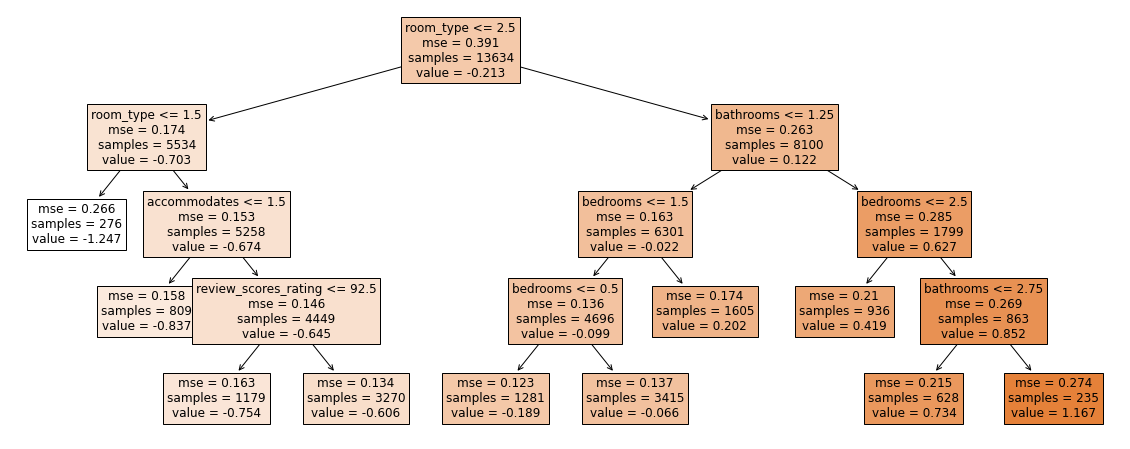

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 8))
plot_tree(model2, feature_names=xname, filled=True, fontsize=12)
plt.show()

**room_type이 가장 먼저 나타남. house인 경우에는 화장실의 개수가 가격에 영향을 줌. private room인 경우에는 수용인원이 가격에 영향을 줌.**

### 3.3 MLPRegressor

**표준화**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
np.random.seed(0)
grid = {'hidden_layer_sizes':[(3,), (4,), (5,), (3, 3), (3, 4), (3, 5), 
                              (4, 3), (4, 4), (4, 5), (5, 3), (5, 4), (5, 5)]}
g_cv = GridSearchCV(MLPRegressor(random_state=0, max_iter=1000),
                    param_grid=grid, cv=3, scoring='neg_mean_absolute_error')
g_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=1000, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state=0, shuffle=True, solver='adam',
                                    tol=0.0001, validation_fraction=0.1,
                                    verbose=False, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'hidden_layer_sizes': [(3,), (4,), (5,), (3, 3),
 

In [ ]:
print('selected:',g_cv.best_params_)
print('score   :',g_cv.best_score_)

selected: {'hidden_layer_sizes': (4,)}
score   : -0.2989454302137876


In [ ]:
model3 = MLPRegressor(hidden_layer_sizes=(4), random_state=0)
model3.fit(X_train_scaled, y_train)
y_pred3 = model3.predict(X_test_scaled)

### 3.4  SVR (linear)

In [ ]:
from sklearn.svm import SVR

In [ ]:
np.random.seed(0)
grid = {'C': np.arange(0.3, 0.33, 0.01)}
g_cv = GridSearchCV(SVR(kernel='linear', max_iter=1000), 
                    param_grid=grid, cv=3, scoring='neg_mean_absolute_error')
g_cv.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='linear',
                           max_iter=1000, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.3 , 0.31, 0.32, 0.33])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print('selected:',g_cv.best_params_)
print('score   :',g_cv.best_score_)

selected: {'C': 0.3}
score   : -0.5927179107781698


In [ ]:
model4 = SVR(kernel='linear', C=0.3)
model4.fit(X_train_scaled, y_train)
y_pred4 = model4.predict(X_test_scaled)

### 3.5 SVR (rbf)

In [ ]:
np.random.seed(0)
grid = {'C': np.arange(0.4, 0.5, 0.05)}
g_cv = GridSearchCV(SVR(kernel='rbf'), param_grid=grid, cv=3, scoring='neg_mean_absolute_error')
g_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.4 , 0.45])}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print('selected:',g_cv.best_params_)
print('score   :',g_cv.best_score_)

selected: {'C': 0.45}
score   : -0.2991806366888174


In [ ]:
model5 = SVR(kernel='rbf', C=0.45)
model5.fit(X_train_scaled, y_train)
y_pred5 = model5.predict(X_test_scaled)

### 3.6 BaggingRegressor

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
model6 = BaggingRegressor(n_estimators=100, random_state=0)
model6.fit(X_train, y_train)
y_pred6 = model6.predict(X_test)

### 3.7 RandomForestRegressor

In [ ]:
np.random.seed(0)
grid = {'max_features': ["sqrt",4,5,6]}
g_cv = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=0), 
                    param_grid=grid, cv=3, scoring='neg_mean_absolute_error')
g_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [ ]:
print('selected:',g_cv.best_params_)
print('score   :',g_cv.best_score_)

selected: {'max_features': 'sqrt'}
score   : -0.2941952018160485


In [ ]:
model7 = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=0)
model7.fit(X_train, y_train)
y_pred7 = model7.predict(X_test)

### 3.8 AdaBoostRegressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
model8 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), n_estimators=100, random_state=0)
model8.fit(X_train, y_train)
y_pred8 = model8.predict(X_test)

### 3.9 GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
np.random.seed(0)
grid = {'max_depth': [3,4,5,6,7]}
g_cv = GridSearchCV(GradientBoostingRegressor(n_estimators=100, random_state=0), 
                    param_grid=grid, cv=3, scoring='neg_mean_absolute_error')
g_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [ ]:
print('selected:',g_cv.best_params_)
print('score   :',g_cv.best_score_)

selected: {'max_depth': 5}
score   : -0.2880812936365689


In [ ]:
model9 = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=0)
model9.fit(X_train, y_train)
y_pred9 = model9.predict(X_test)

# 예측력 비교
**평가시 기준은 MAE와 예측 $R^2$를 사용**

In [ ]:
!pip install mean_absolute_percentage_error

ERROR: Could not find a version that satisfies the requirement mean_absolute_percentage_error (from versions: none)
ERROR: No matching distribution found for mean_absolute_percentage_error


In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

**Lineplot을 그리는데, x축은 방법이름, y축은 MAE인 그래프로 그림**

In [ ]:
mae_table = pd.DataFrame([['LinearRegression', mae(y_test, y_pred1)], 
                          ['DecisionTreeRegressor', mae(y_test, y_pred2)], 
                          ['MLPRegressor', mae(y_test, y_pred3)], 
                          ['SVR (linear)', mae(y_test, y_pred4)], 
                          ['SVR (rbf)', mae(y_test, y_pred5)], 
                          ['BaggingRegressor', mae(y_test, y_pred6)], 
                          ['RandomForestRegressor', mae(y_test, y_pred7)], 
                          ['AdaBoostRegressor', mae(y_test, y_pred8)], 
                          ['GradientBoostingRegressor', mae(y_test, y_pred9)]], 
                         columns=['Model', 'MAE'])

In [ ]:
mae_table

,Model,MAE
0,LinearRegression,0.307835
1,DecisionTreeRegressor,0.308230
2,MLPRegressor,0.301777
3,SVR (linear),0.307472
4,SVR (rbf),0.300097
5,BaggingRegressor,0.295809
6,RandomForestRegressor,0.293236
7,AdaBoostRegressor,0.297754
8,GradientBoostingRegressor,0.289581


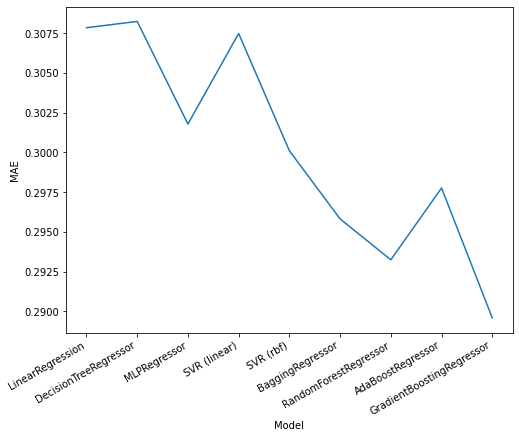

In [ ]:
plt.subplots(figsize=(8, 6))
g=sns.lineplot(data=mae_table, x="Model", y="MAE")
g.set_xticklabels(mae_table['Model'], rotation=30, horizontalalignment='right')
plt.show()

**Lineplot을 그리는데, x축은 방법이름, y축은 예측$R^2$인 그래프로 그린다.**

In [ ]:
from sklearn.metrics import r2_score as r2
r2_table = pd.DataFrame([['LinearRegression', r2(y_test, y_pred1)], 
                           ['DecisionTreeRegressor', r2(y_test, y_pred2)], 
                           ['MLPRegressor', r2(y_test, y_pred3)], 
                           ['SVR (linear)', r2(y_test, y_pred4)],
                           ['SVR (rbf)', r2(y_test, y_pred5)], 
                           ['BaggingRegressor', r2(y_test, y_pred6)],
                           ['RandomForestRegressor', r2(y_test, y_pred7)], 
                           ['AdaBoostRegressor', r2(y_test, y_pred8)],
                           ['GradientBoostingRegressor', r2(y_test, y_pred9)]], 
                          columns=['Model', 'R2'])

In [ ]:
r2_table

,Model,R2
0,LinearRegression,0.602536
1,DecisionTreeRegressor,0.598563
2,MLPRegressor,0.616677
3,SVR (linear),0.601510
4,SVR (rbf),0.617347
5,BaggingRegressor,0.627889
6,RandomForestRegressor,0.634431
7,AdaBoostRegressor,0.627941
8,GradientBoostingRegressor,0.646236


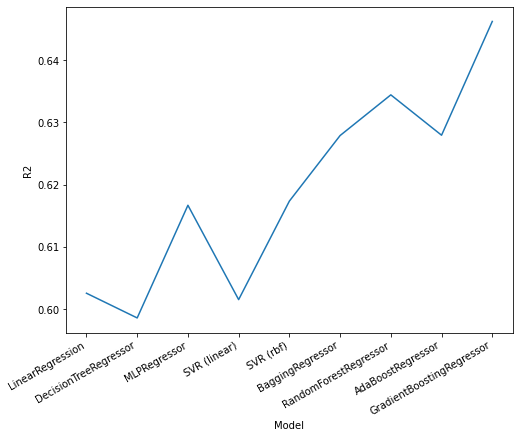

In [ ]:
plt.subplots(figsize=(8, 6))
g=sns.lineplot(data=r2_table, x="Model", y="R2")
g.set_xticklabels(r2_table['Model'], rotation=30, horizontalalignment='right')
plt.show()